# LSTM with attention for stock prediction

## Import Library

In [114]:
!sudo pip install torch==2.0.0 pandas numpy tqdm matplotlib

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

from typing import Any, Dict, List, Tuple

import os
import csv

In [116]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Constants Definition

In [117]:
EXTENDED_FEATURES = [
]
NORMALIZED_FEATURE = [
    'imbalance_size',
    'matched_size',
    'bid_size',
    'ask_size'
]
FILL_ONE_FEATURES = [
    "reference_price", 
    "far_price",
    "near_price",
    "bid_price",
    "ask_price",
    "wap"
]
FILL_MEAN_FEATURES = [
    "imbalance_size", 
    "matched_size"
]
MODEL_INPUT_FEATURES = [
    'imbalance_size', 
    'imbalance_buy_sell_flag',
    'reference_price',
    'matched_size',
    'far_price',
    'near_price',
    'bid_price',
    'bid_size',
    'ask_price',
    'ask_size',
    'wap',
    'target'
]

## Hyper Parameters

In [118]:
BATCH_SIZE: int = 256
EPOCHS: int = 50
LEARNING_RATE: float = 0.0001

## Import Dataset

In [119]:
kaggle_dir = './data'
df = pd.read_csv(os.path.join(kaggle_dir, 'train.csv'))
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [121]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [122]:
def inspect_columns(df):

    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

inspect_columns(df)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0,168,199,int64
date_id,False,481,False,0.00,0,342,480,int64
seconds_in_bucket,False,55,False,0.00,0,300,540,int64
imbalance_size,False,2971863,True,0.00,3180602.69,34523814.87,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0.00,1,-1,-1,int64
reference_price,False,28741,True,0.00,0.999812,1.001926,1.002129,float64
matched_size,False,2948862,True,0.00,13380276.64,503827157.79,24073677.32,float64
far_price,False,95739,True,55.26,NaN,0.987613,1.000859,float64
near_price,False,84625,True,54.55,NaN,0.989055,1.001494,float64
bid_price,False,28313,True,0.00,0.999812,1.001372,1.002129,float64


## Data Splitting

In [123]:
train_df: pd.DataFrame = df.loc[(0 <= df['date_id']) & (df['date_id'] <= 399)]
valid_df: pd.DataFrame = df.loc[(400 <= df['date_id']) & (df['date_id'] <= 477)]
test_df: pd.DataFrame = df.loc[((477 == df['date_id']) & (500 <= df['seconds_in_bucket'])) | ((478 <= df['date_id']) & (df['date_id'] <= 480))]

print(f'The shape of train_df = {train_df.shape}')
print(f'The shape of valid_df = {valid_df.shape}')
print(f'The shape of test_df = {test_df.shape}')

The shape of train_df = (4346980, 17)
The shape of valid_df = (858000, 17)
The shape of test_df = (34000, 17)


## Data Preprocessing After Splitting

### Training Set

In [124]:
def GenPreprocessInfo(raw_df: pd.DataFrame) -> Dict[int, Dict[str, Dict[str, float]]]:
    '''
    Return value example:
    {
        'STOCK_ID': {
            'COLUMN': {
                'min': 0.0,
                'max': 1.0,
                'mean': 0.5
            }
        }
    }
    '''
    data: pd.DataFrame = raw_df.copy()
    statistic_result: Dict[int, Dict[str, Dict[str, float]]] = {}
    
    for stock in data['stock_id'].unique().tolist():
        stock_df: pd.DataFrame = data.loc[data['stock_id'] == stock]
        stock_info: Dict[str, Dict[str, float]] = {}
        
        for feat in stock_df.columns:
            if pd.api.types.is_string_dtype(stock_df[feat]):
                continue
            stock_feat_info: Dict[str, float] = {}
            stock_feat_info['min'] = stock_df[feat].min(skipna=True)
            stock_feat_info['max'] = stock_df[feat].max(skipna=True)
            stock_feat_info['mean'] = stock_df[feat].mean(skipna=True)
            stock_info[feat] = stock_feat_info
        
        statistic_result[stock] = stock_info
    
    return statistic_result

preprocess_info = GenPreprocessInfo(raw_df=train_df)

In [125]:
def PreprocessTrainSet(
    raw_df: pd.DataFrame, statistic_result: Dict[int, Dict[str, Dict[str, float]]]
) -> pd.DataFrame:
    data: pd.DataFrame = raw_df.copy()
    
    # fill out NaN with mean value
    for stock in data['stock_id'].unique().tolist():
        for feat in FILL_MEAN_FEATURES:
            data.loc[
                (data['stock_id'] == stock) & (data[feat].isnull()), 
                feat
            ] = statistic_result[stock][feat]['mean']

    # fill out NaN with 1
    for feat in FILL_ONE_FEATURES:
        data[feat] = data[feat].fillna(1.0)

    # normalize features
    for feat in MODEL_INPUT_FEATURES:
        if feat not in NORMALIZED_FEATURE:
            continue
        data['min'] = np.nan
        data['max'] = np.nan
        
        for stock in data['stock_id'].unique().tolist():
            data.loc[data['stock_id'] == stock, ['min', 'max']] = [
                statistic_result[stock][feat]['min'],
                statistic_result[stock][feat]['max']
            ]
        
        data[feat] = (data[feat] - data['min']) / (data['max'] - data['min'])
        data = data.drop('min', axis=1)
        data = data.drop('max', axis=1)
        
    data.dropna(inplace=True)
    
    print(f'Data has nan: \n{data.isnull().any()}')
    
    return data


train_pp_df = PreprocessTrainSet(raw_df=train_df, statistic_result=preprocess_info)

print(train_pp_df)

Data has nan: 
stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size             False
imbalance_buy_sell_flag    False
reference_price            False
matched_size               False
far_price                  False
near_price                 False
bid_price                  False
bid_size                   False
ask_price                  False
ask_size                   False
wap                        False
target                     False
time_id                    False
row_id                     False
dtype: bool
         stock_id  date_id  seconds_in_bucket  imbalance_size  \
0               0        0                  0        0.023833   
1               1        0                  0        0.014830   
2               2        0                  0        0.015351   
3               3        0                  0        0.037858   
4               4        0                  0        0.005779   
...           ...     

In [126]:
# def PreprocessTrainSet(
#     raw_df: pd.DataFrame
# ) -> Tuple[pd.DataFrame, Dict[int, Dict[str, Dict[str, float]]]]:
#     '''
#     The 2nd return value example:
#     {
#         'STOCK_ID': {
#             'COLUMN': {
#                 'min': 0.0,
#                 'max': 1.0,
#                 'mean': 0.5
#             }
#         }
#     }
#     '''
#     data: pd.DataFrame = raw_df.copy()
#     statistic_result: Dict[int, Dict[str, Dict[str, float]]] = {}
    
#     for stock in data['stock_id'].unique().tolist():
#         stock_df: pd.DataFrame = data.loc[data['stock_id'] == stock]
#         stock_info: Dict[str, Dict[str, float]] = {}
        
#         for feat in stock_df.columns:
#             if pd.api.types.is_string_dtype(stock_df[feat]):
#                 continue
#             stock_feat_info: Dict[str, float] = {}
#             stock_feat_info['min'] = stock_df[feat].min(skipna=True)
#             stock_feat_info['max'] = stock_df[feat].max(skipna=True)
#             stock_feat_info['mean'] = stock_df[feat].mean(skipna=True)
#             stock_info[feat] = stock_feat_info
        
#         statistic_result[stock] = stock_info
    
#     # fill out NaN with mean value
#     for stock in data['stock_id'].unique().tolist():
#         for feat in FILL_MEAN_FEATURES:
#             data.loc[
#                 (data['stock_id'] == stock) & (data[feat].isnull()), 
#                 feat
#             ] = statistic_result[stock][feat]['mean']

#     # fill out NaN with 1
#     for feat in FILL_ONE_FEATURES:
#         data[feat] = data[feat].fillna(1.0)

#     # normalize features
#     for feat in MODEL_INPUT_FEATURES:
#         if feat not in NORMALIZED_FEATURE:
#             continue
#         data['min'] = np.nan
#         data['max'] = np.nan
        
#         for stock in data['stock_id'].unique().tolist():
#             data.loc[data['stock_id'] == stock, ['min', 'max']] = [
#                 statistic_result[stock][feat]['min'],
#                 statistic_result[stock][feat]['max']
#             ]
        
#         data[feat] = (data[feat] - data['min']) / (data['max'] - data['min'])
#         data = data.drop('min', axis=1)
#         data = data.drop('max', axis=1)
        
#     data.dropna(inplace=True)
    
#     print(f'Data has nan: \n{data.isnull().any()}')
    
#     return data, statistic_result


# preprocess_info: Dict[Any, Any]
# train_pp_df, preprocess_info = PreprocessTrainSet(raw_df=train_df)

# print(train_pp_df)

### Validation Set and Test Set

In [127]:
def PreprocessValidationTestSet(
    raw_df: pd.DataFrame, statistic_result: Dict[int, Dict[str, Dict[str, float]]]
) -> pd.DataFrame:

    data: pd.DataFrame = raw_df.copy()
    
    # fill out NaN with mean value
    for stock in data['stock_id'].unique().tolist():
        for feat in FILL_MEAN_FEATURES:
            data.loc[
                (data['stock_id'] == stock) & (data[feat].isnull()), 
                feat
            ] = statistic_result[stock][feat]['mean']

    # fill out NaN with 1
    for feat in FILL_ONE_FEATURES:
        data[feat] = data[feat].fillna(1.0)

    # normalize features
    for feat in MODEL_INPUT_FEATURES:
        if feat not in NORMALIZED_FEATURE:
            continue
        data['min'] = np.nan
        data['max'] = np.nan
        
        for stock in data['stock_id'].unique().tolist():
            data.loc[data['stock_id'] == stock, ['min', 'max']] = [
                statistic_result[stock][feat]['min'],
                statistic_result[stock][feat]['max']
            ]
        
        data[feat] = (data[feat] - data['min']) / (data['max'] - data['min'])
        data = data.drop('min', axis=1)
        data = data.drop('max', axis=1)
        
    data.dropna(inplace=True)
    
    print(f'Data has nan: \n{data.isnull().any()}')
    
    return data

In [128]:
valid_pp_df = PreprocessValidationTestSet(raw_df=valid_df, statistic_result=preprocess_info)
valid_pp_df

Data has nan: 
stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size             False
imbalance_buy_sell_flag    False
reference_price            False
matched_size               False
far_price                  False
near_price                 False
bid_price                  False
bid_size                   False
ask_price                  False
ask_size                   False
wap                        False
target                     False
time_id                    False
row_id                     False
dtype: bool


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
4346980,0,400,0,0.104640,1,0.999454,0.026447,1.000000,1.000000,0.999648,0.001736,1.000521,0.015102,1.000000,0.050068,22000,400_0_0
4346981,1,400,0,0.178324,1,0.998651,0.025849,1.000000,1.000000,0.998065,0.049754,1.002580,0.045598,1.000000,-10.010004,22000,400_0_1
4346982,2,400,0,0.097252,-1,1.000470,0.011749,1.000000,1.000000,0.999974,0.007547,1.001236,0.103731,1.000000,7.070303,22000,400_0_2
4346983,3,400,0,0.020171,1,1.000143,0.032162,1.000000,1.000000,0.999964,0.004982,1.000731,0.153409,1.000000,3.780127,22000,400_0_3
4346984,4,400,0,0.071687,1,0.999428,0.008230,1.000000,1.000000,0.999255,0.016142,1.000119,0.004565,1.000000,1.590252,22000,400_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204975,195,477,540,0.040944,-1,1.002359,0.120353,1.001253,1.001253,1.002359,0.153837,1.002482,0.318110,1.002429,-3.190041,26289,477_540_195
5204976,196,477,540,0.045124,-1,0.998663,0.148910,0.996644,0.997401,0.998663,0.078859,0.999168,0.079631,0.998803,-6.200075,26289,477_540_196
5204977,197,477,540,0.004787,1,0.997623,0.024257,0.998388,0.998388,0.997240,0.013190,0.997623,0.033533,0.997405,0.000000,26289,477_540_197
5204978,198,477,540,0.027363,-1,0.999832,0.054122,0.998511,0.998751,0.999712,0.249313,0.999952,0.303272,0.999797,1.300573,26289,477_540_198


In [129]:
test_pp_df = PreprocessValidationTestSet(raw_df=test_df, statistic_result=preprocess_info)
test_pp_df

Data has nan: 
stock_id                   False
date_id                    False
seconds_in_bucket          False
imbalance_size             False
imbalance_buy_sell_flag    False
reference_price            False
matched_size               False
far_price                  False
near_price                 False
bid_price                  False
bid_size                   False
ask_price                  False
ask_size                   False
wap                        False
target                     False
time_id                    False
row_id                     False
dtype: bool


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5203980,0,477,500,0.010121,-1,0.998733,0.149994,0.998383,0.998383,0.998733,0.009558,0.998908,0.062429,0.998816,-1.959801,26285,477_500_0
5203981,1,477,500,0.019167,-1,0.996861,0.230179,0.996761,0.996811,0.996861,0.022933,0.997110,0.003114,0.997068,-3.240108,26285,477_500_1
5203982,2,477,500,0.008084,1,1.000412,0.025736,1.000618,1.000618,1.000206,0.007384,1.000412,0.002194,1.000306,2.800226,26285,477_500_2
5203983,3,477,500,0.023070,-1,0.999988,0.065996,0.998009,0.998603,0.999988,0.006517,1.000087,0.032960,1.000011,-5.049705,26285,477_500_3
5203984,4,477,500,0.000000,0,1.001033,0.075482,1.001033,1.001033,1.001033,0.093155,1.001089,0.006674,1.001087,-1.299977,26285,477_500_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,0.035571,-1,1.000317,0.092998,0.999734,0.999734,1.000317,0.011651,1.000434,0.311774,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,0.012758,-1,1.000643,0.155865,1.000129,1.000386,1.000643,0.446159,1.000900,0.078257,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.000000,0,0.995789,0.030443,0.995789,0.995789,0.995789,0.010616,0.995883,0.219793,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,0.004784,1,0.999210,0.090585,0.999210,0.999210,0.998970,0.058164,0.999210,0.209937,0.999008,-1.540184,26454,480_540_198


## Create DataLoaders for Training And Validation

In [130]:
def GenTimeSeriesData(raw_df: pd.DataFrame) -> Tuple[np.ndarray, np.float32]:
    '''
    raw_df: The rows of time t-n ~ t for predicting the target of t.
    The generated features contains the data of time t-n ~ t-1.
    '''
    df = raw_df.copy()
    df = df.sort_values(by=['date_id', 'seconds_in_bucket'], ascending=True)
    
    df = df[MODEL_INPUT_FEATURES]
    df_numpy: np.ndarray = df.to_numpy()
    
    x: np.ndarray = df_numpy[:-1, :]
    y: np.float32 = df['target'].tolist()[-1]
    
    return x, y

def GenTimeSeriesDataset(
    train_raw_df: pd.DataFrame, valid_raw_df: pd.DataFrame, window_size: int
) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray
]:
    '''
    Generate train_x, train_y, valid_x, valid_y
    '''
    train_x: List[np.ndarray] = []
    train_y: List[np.float32] = []
    valid_x: List[np.ndarray] = []
    valid_y: List[np.float32] = []
    
    data: pd.DataFrame = pd.concat([train_raw_df, valid_raw_df], ignore_index=True)
    data = data.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'], ascending=True)
    train_date: List[int] = train_raw_df['date_id'].unique().tolist()
    valid_date: List[int] = valid_raw_df['date_id'].unique().tolist()
    
    with tqdm(total=data.shape[0]) as pbar:
        pbar.set_description('Preparing time series dataset')
        for stock in data['stock_id'].unique().tolist():
            stock_df: pd.DataFrame = data.loc[data['stock_id'] == stock].reset_index(drop=True)
            stock_df.reset_index(drop=True, inplace=True)
            
            for date in range(0, 478):
                for second in range(0, 540+1, 10):
                    index_list: List[int] = stock_df.index[
                        (stock_df['stock_id'] == stock) & 
                        (stock_df['date_id'] == date) & 
                        (stock_df['seconds_in_bucket'] == second)
                    ].tolist()
                    
                    if len(index_list) == 0:
                        continue
                    pbar.update(1)
                    if index_list[0] < window_size:
                        continue
                    
                    x: np.ndarray
                    y: np.float32
                    start_idx, end_idx = index_list[0] - window_size, index_list[0] + 1
                    x, y = GenTimeSeriesData(raw_df=stock_df.iloc[start_idx:end_idx])
                    
                    if date in train_date:
                        train_x.append(x)
                        train_y.append(y)
                    elif date in valid_date:
                        valid_x.append(x)
                        valid_y.append(y)
    
    return np.array(train_x), np.array(train_y), np.array(valid_x), np.array(valid_y)

In [17]:
train_set_x: np.ndarray
train_set_y: np.ndarray
valid_set_x: np.ndarray
valid_set_y: np.ndarray

# train_set_x, train_set_y, valid_set_x, valid_set_y = GenTimeSeriesDataset(
#     train_raw_df=train_pp_df, valid_raw_df=valid_pp_df, window_size=5
# )

In [56]:
train_set_x = train_set_x.astype(np.float32)
train_set_y = train_set_y.astype(np.float32)
valid_set_x = valid_set_x.astype(np.float32)
valid_set_y = valid_set_y.astype(np.float32)

In [47]:
train_set_y = train_set_y[:, np.newaxis]
valid_set_y = valid_set_y[:, np.newaxis]

In [143]:
print(train_set_x.shape)
print(train_set_y.shape)
print(valid_set_x.shape)
print(valid_set_y.shape)

(4345893, 5, 12)
(4345893, 1)
(857999, 5, 12)
(857999, 1)


In [30]:
with open('./numpy_bin/train_set_x.npy', 'wb') as f:
    np.save(f, train_set_x)
with open('./numpy_bin/train_set_y.npy', 'wb') as f:
    np.save(f, train_set_y)
with open('./numpy_bin/valid_set_x.npy', 'wb') as f:
    np.save(f, valid_set_x)
with open('./numpy_bin/valid_set_y.npy', 'wb') as f:
    np.save(f, valid_set_y)

In [131]:
train_set_x = np.load('./numpy_bin/new_time_period/train_set_2_x.npy', allow_pickle=True).astype(np.float32)
train_set_y = np.load('./numpy_bin/new_time_period/train_set_2_y.npy', allow_pickle=True).astype(np.float32)
valid_set_x = np.load('./numpy_bin/new_time_period/valid_set_2_x.npy', allow_pickle=True).astype(np.float32)
valid_set_y = np.load('./numpy_bin/new_time_period/valid_set_2_y.npy', allow_pickle=True).astype(np.float32)

if train_set_y.ndim == 1:
    train_set_y = train_set_y[:, np.newaxis]
if valid_set_y.ndim == 1:
    valid_set_y = valid_set_y[:, np.newaxis]

In [132]:
print(train_set_x.shape)
print(train_set_y.shape)
print(valid_set_x.shape)
print(valid_set_y.shape)

(4345893, 5, 12)
(4345893, 1)
(857999, 5, 12)
(857999, 1)


In [133]:
train_set_x_torch, train_set_y_torch, valid_set_x_torch, valid_set_y_torch = (
    torch.tensor(train_set_x).clone().detach(),
    torch.tensor(train_set_y).clone().detach(),
    torch.tensor(valid_set_x).clone().detach(),
    torch.tensor(valid_set_y).clone().detach()
)

train_loader = DataLoader(TensorDataset(train_set_x_torch, train_set_y_torch), shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(TensorDataset(valid_set_x_torch, valid_set_y_torch), shuffle=True, batch_size=BATCH_SIZE)

## Model Definition

In [134]:
class AttentionLSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_heads=64, batch_first=True, dropout=0.1):
        super(AttentionLSTM_Model, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, dropout=dropout)
        self.multihead_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads)
        self.linear = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # LSTM
        lstm_output, _ = self.lstm(x)

        # Multihead Attention
        lstm_output = lstm_output.permute(1, 0, 2)  # Change the sequence format for MultiheadAttention
        attention_output, _ = self.multihead_attention(lstm_output, lstm_output, lstm_output)
        attention_output = attention_output.permute(1, 0, 2)  # Change the sequence format back to the original

        # Linear layer
        x = self.dropout(attention_output)
        x = self.linear(x[:, -1, :])
        return x

## Training

In [135]:
def train(
    model, train_loader: DataLoader, valid_loader: DataLoader, optimizer, loss_fn, epoch_cnt: int
) -> Tuple[List[float], List[float]]:
    train_loss_list: List[float] = []
    valid_loss_list: List[float] = []
    
    print(f'The batch size of train_loader = {train_loader.batch_size}')
    print(f'The batch size of valid_loader = {valid_loader.batch_size}')

    min_loss: float = 10.0
    
    for epoch in range(epoch_cnt):
        train_batch_loss_list: List[float] = []
        valid_batch_loss_list: List[float] = []
        
        model.train()
        pbar = tqdm(train_loader)
        pbar.set_description(f"Training Epoch {epoch}")
        for batch_x, batch_y in pbar:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
            train_batch_loss_list.append(loss.cpu().detach().numpy())
            
            loss.backward()
            optimizer.step()

            if len(train_batch_loss_list) % 1000 == 999:
                train_loss_list.append(float(np.mean(train_batch_loss_list[-100:])))
        
        model.eval()
        better_model: bool = False
        with torch.no_grad():
            pbar = tqdm(valid_loader)
            pbar.set_description(f"Validating Epoch {epoch}")
            for batch_x, batch_y in pbar:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                
                pred_y = model(batch_x)
                loss = loss_fn(pred_y, batch_y)
                valid_batch_loss_list.append(loss.cpu().detach().numpy())

                if len(valid_batch_loss_list) % 1000 == 999:
                    if len(valid_loss_list) == 0 or float(np.mean(valid_batch_loss_list[-100:])) < min_loss:
                        better_model = True
                        min_loss = float(np.mean(valid_batch_loss_list[-100:]))
                    valid_loss_list.append(float(np.mean(valid_batch_loss_list[-100:])))

        if better_model:
            torch.save(model, f"./models/lstm-with-attention-t2t4-bs{BATCH_SIZE}-lr{LEARNING_RATE}.pt")
        
        print("Epoch %d: train_loss %.4f, val_loss %.4f" % (epoch, np.mean(train_batch_loss_list), np.mean(valid_batch_loss_list)))
        
    return train_loss_list, valid_loss_list

In [136]:
model = AttentionLSTM_Model(input_size=len(MODEL_INPUT_FEATURES))
model.to(device)

AttentionLSTM_Model(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True, dropout=0.1)
  (multihead_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [137]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.L1Loss()

In [138]:
train_loss_list: List[float] = []
valid_loss_list: List[float] = []
train_loss_list, valid_loss_list = train(
    model=model, 
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    optimizer=optimizer, 
    loss_fn=loss_fn, 
    epoch_cnt=EPOCHS
)

The batch size of train_loader = 256
The batch size of valid_loader = 256


Validating Epoch 0: 100%|██████████| 3352/3352 [00:05<00:00, 589.21it/s]


Epoch 0: train_loss 4.2222, val_loss 3.6315


Validating Epoch 1: 100%|██████████| 3352/3352 [00:05<00:00, 560.39it/s]


Epoch 1: train_loss 4.1305, val_loss 3.6039


Validating Epoch 2: 100%|██████████| 3352/3352 [00:05<00:00, 591.28it/s]


Epoch 2: train_loss 4.1167, val_loss 3.6231


Validating Epoch 3: 100%|██████████| 3352/3352 [00:05<00:00, 592.19it/s]


Epoch 3: train_loss 4.1024, val_loss 3.5829


Validating Epoch 4: 100%|██████████| 3352/3352 [00:05<00:00, 587.72it/s]


Epoch 4: train_loss 4.0895, val_loss 3.5785


Validating Epoch 5: 100%|██████████| 3352/3352 [00:05<00:00, 560.32it/s]


Epoch 5: train_loss 4.0782, val_loss 3.5726


Validating Epoch 6: 100%|██████████| 3352/3352 [00:06<00:00, 553.57it/s]


Epoch 6: train_loss 4.0702, val_loss 3.5556


Validating Epoch 7: 100%|██████████| 3352/3352 [00:05<00:00, 570.01it/s]


Epoch 7: train_loss 4.0631, val_loss 3.5535


Validating Epoch 8: 100%|██████████| 3352/3352 [00:05<00:00, 602.53it/s]


Epoch 8: train_loss 4.0572, val_loss 3.5436


Validating Epoch 9: 100%|██████████| 3352/3352 [00:05<00:00, 599.26it/s]


Epoch 9: train_loss 4.0511, val_loss 3.5368


Validating Epoch 10: 100%|██████████| 3352/3352 [00:05<00:00, 599.19it/s]


Epoch 10: train_loss 4.0470, val_loss 3.5421


Validating Epoch 11: 100%|██████████| 3352/3352 [00:05<00:00, 572.41it/s]


Epoch 11: train_loss 4.0417, val_loss 3.5404


Validating Epoch 12: 100%|██████████| 3352/3352 [00:05<00:00, 606.47it/s]


Epoch 12: train_loss 4.0385, val_loss 3.5451


Validating Epoch 13: 100%|██████████| 3352/3352 [00:05<00:00, 607.88it/s]


Epoch 13: train_loss 4.0344, val_loss 3.5250


Validating Epoch 14: 100%|██████████| 3352/3352 [00:05<00:00, 606.41it/s]


Epoch 14: train_loss 4.0318, val_loss 3.5272


Validating Epoch 15: 100%|██████████| 3352/3352 [00:05<00:00, 604.80it/s]


Epoch 15: train_loss 4.0289, val_loss 3.5339


Validating Epoch 16: 100%|██████████| 3352/3352 [00:05<00:00, 574.35it/s]


Epoch 16: train_loss 4.0261, val_loss 3.5217


Validating Epoch 17: 100%|██████████| 3352/3352 [00:05<00:00, 606.90it/s]


Epoch 17: train_loss 4.0234, val_loss 3.5257


Validating Epoch 18: 100%|██████████| 3352/3352 [00:05<00:00, 608.73it/s]


Epoch 18: train_loss 4.0206, val_loss 3.5266


Validating Epoch 19: 100%|██████████| 3352/3352 [00:05<00:00, 580.12it/s]


Epoch 19: train_loss 4.0177, val_loss 3.5144


Validating Epoch 20: 100%|██████████| 3352/3352 [00:05<00:00, 603.60it/s]


Epoch 20: train_loss 4.0153, val_loss 3.5132


Validating Epoch 21: 100%|██████████| 3352/3352 [00:06<00:00, 557.17it/s]


Epoch 21: train_loss 4.0130, val_loss 3.5092


Validating Epoch 22: 100%|██████████| 3352/3352 [00:05<00:00, 603.23it/s]


Epoch 22: train_loss 4.0100, val_loss 3.5084


Validating Epoch 23: 100%|██████████| 3352/3352 [00:05<00:00, 563.32it/s]


Epoch 23: train_loss 4.0081, val_loss 3.5094


Validating Epoch 24: 100%|██████████| 3352/3352 [00:05<00:00, 560.98it/s]


Epoch 24: train_loss 4.0055, val_loss 3.5052


Validating Epoch 25: 100%|██████████| 3352/3352 [00:05<00:00, 602.90it/s]


Epoch 25: train_loss 4.0036, val_loss 3.5181


Validating Epoch 26: 100%|██████████| 3352/3352 [00:05<00:00, 590.78it/s]


Epoch 26: train_loss 4.0013, val_loss 3.5034


Validating Epoch 27: 100%|██████████| 3352/3352 [00:05<00:00, 600.41it/s]


Epoch 27: train_loss 3.9995, val_loss 3.5002


Validating Epoch 28: 100%|██████████| 3352/3352 [00:05<00:00, 607.16it/s]


Epoch 28: train_loss 3.9975, val_loss 3.5088


Validating Epoch 29: 100%|██████████| 3352/3352 [00:05<00:00, 573.65it/s]


Epoch 29: train_loss 3.9962, val_loss 3.5014


Validating Epoch 30: 100%|██████████| 3352/3352 [00:05<00:00, 607.87it/s]


Epoch 30: train_loss 3.9939, val_loss 3.5024


Validating Epoch 31: 100%|██████████| 3352/3352 [00:05<00:00, 598.46it/s]


Epoch 31: train_loss 3.9917, val_loss 3.5010


Validating Epoch 32: 100%|██████████| 3352/3352 [00:05<00:00, 598.02it/s]


Epoch 32: train_loss 3.9899, val_loss 3.5002


Validating Epoch 33: 100%|██████████| 3352/3352 [00:05<00:00, 607.19it/s]


Epoch 33: train_loss 3.9883, val_loss 3.5090


Validating Epoch 34: 100%|██████████| 3352/3352 [00:05<00:00, 579.60it/s]


Epoch 34: train_loss 3.9864, val_loss 3.4953


Validating Epoch 35: 100%|██████████| 3352/3352 [00:05<00:00, 606.03it/s]


Epoch 35: train_loss 3.9847, val_loss 3.4964


Validating Epoch 36: 100%|██████████| 3352/3352 [00:05<00:00, 605.25it/s]


Epoch 36: train_loss 3.9835, val_loss 3.4998


Validating Epoch 37: 100%|██████████| 3352/3352 [00:05<00:00, 597.29it/s]


Epoch 37: train_loss 3.9821, val_loss 3.4854


Validating Epoch 38: 100%|██████████| 3352/3352 [00:05<00:00, 607.42it/s]


Epoch 38: train_loss 3.9802, val_loss 3.4923


Validating Epoch 39: 100%|██████████| 3352/3352 [00:05<00:00, 578.89it/s]


Epoch 39: train_loss 3.9790, val_loss 3.4898


Validating Epoch 40: 100%|██████████| 3352/3352 [00:05<00:00, 604.57it/s]


Epoch 40: train_loss 3.9783, val_loss 3.4897


Validating Epoch 41: 100%|██████████| 3352/3352 [00:05<00:00, 605.17it/s]


Epoch 41: train_loss 3.9769, val_loss 3.4907


Validating Epoch 42: 100%|██████████| 3352/3352 [00:05<00:00, 581.36it/s]


Epoch 42: train_loss 3.9760, val_loss 3.4879


Validating Epoch 43: 100%|██████████| 3352/3352 [00:05<00:00, 604.79it/s]


Epoch 43: train_loss 3.9751, val_loss 3.4906


Validating Epoch 44: 100%|██████████| 3352/3352 [00:05<00:00, 572.67it/s]


Epoch 44: train_loss 3.9747, val_loss 3.4971


Validating Epoch 45: 100%|██████████| 3352/3352 [00:05<00:00, 609.73it/s]


Epoch 45: train_loss 3.9734, val_loss 3.5014


Validating Epoch 46: 100%|██████████| 3352/3352 [00:05<00:00, 602.10it/s]


Epoch 46: train_loss 3.9729, val_loss 3.4795


Validating Epoch 47: 100%|██████████| 3352/3352 [00:05<00:00, 577.25it/s]


Epoch 47: train_loss 3.9717, val_loss 3.4789


Validating Epoch 48: 100%|██████████| 3352/3352 [00:05<00:00, 605.07it/s]


Epoch 48: train_loss 3.9704, val_loss 3.4793


Validating Epoch 49: 100%|██████████| 3352/3352 [00:05<00:00, 606.19it/s]

Epoch 49: train_loss 3.9700, val_loss 3.4835


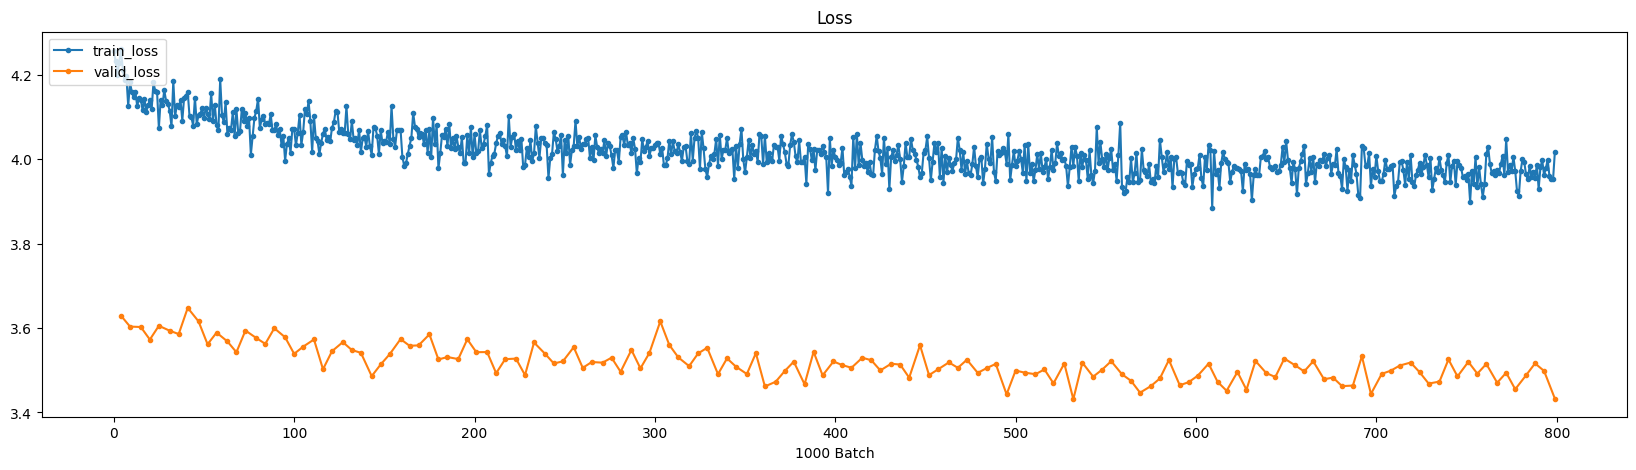

In [139]:
# loss graph
fig = plt.figure(figsize=(45, 5))
ax1 = fig.add_subplot(1, 2, 1)

train_loss_x_axis: List[int] = np.arange(len(train_loss_list)).tolist()
valid_loss_x_axis: List[int] = np.arange(start=len(train_loss_list)-1, stop=-1, step=(len(train_loss_list)/len(valid_loss_list))*-1, dtype=np.float32).astype(np.int32).tolist()[::-1]

ax1.set_title('Loss')
ax1.plot(train_loss_x_axis, train_loss_list, marker='.')
ax1.plot(valid_loss_x_axis, valid_loss_list, marker='.')
ax1.legend(['train_loss', 'valid_loss'], loc='upper left')
ax1.set_xlabel('1000 Batch')
plt.show()

## Testing

In [140]:
class TimeSeriesDataset(Dataset):
    def __init__(self, raw_df: pd.DataFrame, window_size: int) -> None:
        super().__init__()
        self.data: pd.DataFrame = raw_df.copy()
        self.window_size: int = window_size
        self.stock_dfs: Dict[int, pd.DataFrame]
        self.idx_map: Dict[int, Dict[str, int]]
        self.stock_dfs, self.idx_map = TimeSeriesDataset._SplitStockDataFrame(raw_df=self.data, window_size=self.window_size)
    

    def __getitem__(self, _index: int) -> Tuple[np.ndarray, np.ndarray, int, int, int]:
        '''
        return x, y, date_id, seconds_in_buckets, stock_id
        '''
        index: int = _index
        stock: int = self.idx_map[index]['stock']
        stock_idx: int = self.idx_map[index]['idx']

        start_idx, end_idx = stock_idx - (self.window_size - 1), stock_idx + 1
        return TimeSeriesDataset._GenTimeSeriesData(raw_df=self.stock_dfs[stock].iloc[start_idx:end_idx])


    def __len__(self) -> int:
        return len(self.idx_map)
    
    def FillTarget(self, stock: int, date: int, second: int, value: np.float32) -> None:
        if stock not in self.stock_dfs:
            return
        self.stock_dfs[stock].loc[(self.stock_dfs[stock]['date_id'] == date) & (self.stock_dfs[stock]['seconds_in_bucket'] == second), 'pred_target'] = value
    
    @staticmethod
    def _GenTimeSeriesData(raw_df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, int, int, int]:
        '''
        raw_df: The rows of time t-n ~ t for predicting the target of t.
        The generated features contains the data of time t-n ~ t-1.
        return x, y, date_id, seconds_in_buckets, stock_id
        '''
        df = raw_df.copy()
        df = df.sort_values(by=['date_id', 'seconds_in_bucket'], ascending=True)

        date: int = df['date_id'].tolist()[-1]
        second: int = df['seconds_in_bucket'].tolist()[-1]
        stock: int = df['stock_id'].tolist()[-1]
        y: np.float32 = df['target'].tolist()[-1]

        pred_target_not_null_indices = df['pred_target'].notnull()
        df.loc[pred_target_not_null_indices, 'target'] = df.loc[pred_target_not_null_indices, 'pred_target']
        
        df = df[MODEL_INPUT_FEATURES]
        df_numpy: np.ndarray = df.to_numpy()
        df_numpy[-1, MODEL_INPUT_FEATURES.index('target')] = 0
        
        # x: np.ndarray = df_numpy[:-1, :]
        x: np.ndarray = df_numpy
        
        return x.astype(np.float32), np.array(y).astype(np.float32), date, second, stock
    
    @staticmethod
    def _SplitStockDataFrame(raw_df: pd.DataFrame, window_size: int) -> Tuple[Dict[int, pd.DataFrame], Dict[int, Dict[str, int]]]:
        stock_dfs: Dict[int, pd.DataFrame] = {}
        idx_map: Dict[int, Dict[str, int]] = {}

        data: pd.DataFrame = raw_df.copy()
        data = data.sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id'], ascending=True)
        data.reset_index(drop=True, inplace=True)
        data_idx_offset: int = 5 * 200

        for stock in data['stock_id'].unique().tolist():
            stock_df: pd.DataFrame = data.copy().loc[data['stock_id'] == stock]
            stock_df.insert(stock_df.shape[1], 'new_idx', range(stock_df.shape[0]))
            stock_df.insert(stock_df.shape[1], 'pred_target', np.nan)
            for idx, row in stock_df.iterrows():
                if row['new_idx'] < window_size:
                    continue
                stock_idx_map: Dict[str, int] = {'stock': stock, 'idx': row['new_idx']}
                idx_map[int(idx) - data_idx_offset] = stock_idx_map
            stock_df.reset_index(drop=True, inplace=True)
            stock_df.drop('new_idx', axis=1, inplace=True)
            stock_dfs[stock] = stock_df

        return stock_dfs, idx_map

In [141]:
test_dataset: TimeSeriesDataset = TimeSeriesDataset(raw_df=test_pp_df, window_size=5)

In [142]:
print(test_dataset[3001])

(array([[ 1.00501455e-01, -1.00000000e+00,  1.00222695e+00,
         8.06415230e-02,  1.00000000e+00,  1.00000000e+00,
         1.00176895e+00,  1.75893139e-02,  1.00298905e+00,
         2.76037063e-02,  1.00214100e+00,  1.73902512e+01],
       [ 1.00501455e-01, -1.00000000e+00,  1.00237894e+00,
         8.06415230e-02,  1.00000000e+00,  1.00000000e+00,
         1.00227702e+00,  6.41890382e-03,  1.00298905e+00,
         2.62847077e-02,  1.00238097e+00,  1.48999691e+01],
       [ 1.00501455e-01, -1.00000000e+00,  1.00288701e+00,
         8.06415230e-02,  1.00000000e+00,  1.00000000e+00,
         1.00278497e+00,  4.80769612e-02,  1.00339496e+00,
         1.38917761e-02,  1.00321400e+00,  4.86969948e+00],
       [ 1.00501455e-01, -1.00000000e+00,  1.00293803e+00,
         8.06415230e-02,  1.00000000e+00,  1.00000000e+00,
         1.00278497e+00,  9.12206993e-03,  1.00339496e+00,
         4.02824618e-02,  1.00286806e+00,  6.43968582e+00],
       [ 1.00501455e-01, -1.00000000e+00,  1.002887

In [143]:
test_dataset.FillTarget(stock=0, date=477, second=540, value=np.float32(12))
print(test_dataset[0])

(array([[ 1.0121399e-02, -1.0000000e+00,  9.9873298e-01,  1.4999378e-01,
         9.9838299e-01,  9.9838299e-01,  9.9873298e-01,  1.9949861e-02,
         9.9890798e-01,  1.7002003e-01,  9.9880499e-01, -1.6599894e+00],
       [ 9.9188332e-03, -1.0000000e+00,  9.9873298e-01,  1.5011580e-01,
         9.9838299e-01,  9.9838299e-01,  9.9873298e-01,  1.8082341e-02,
         9.9890798e-01,  1.8907678e-01,  9.9879599e-01, -2.3007393e-01],
       [ 9.9188332e-03, -1.0000000e+00,  9.9873298e-01,  1.5011580e-01,
         9.9838299e-01,  9.9838299e-01,  9.9873298e-01,  2.3210764e-02,
         9.9890798e-01,  3.3625606e-01,  9.9878401e-01,  1.5103817e+00],
       [ 2.9611750e-02, -1.0000000e+00,  9.9899602e-01,  1.3825254e-01,
         9.9838299e-01,  9.9838299e-01,  9.9890798e-01,  1.9062987e-02,
         9.9908298e-01,  1.0952274e-01,  9.9899697e-01,  1.2000000e+01],
       [ 2.8125461e-02, -1.0000000e+00,  9.9987501e-01,  3.3345934e-02,
         1.0000000e+00,  1.0000000e+00,  9.9987501e-01,  3.

In [144]:
def test(
    model, test_set: TimeSeriesDataset
) -> pd.DataFrame:
    
    result: pd.DataFrame = pd.DataFrame(columns=['date_id', 'seconds_in_bucket', 'stock_id', 'time_id', 'row_id', 'target'])

    model.eval()
    with torch.no_grad():
        with tqdm(total=len(test_set)) as pbar:
            pbar.set_description(f"Testing")
            for iter in range(len(test_set)):
                batch_x, batch_y, date, second, stock = test_set[iter]

                batch_x = torch.from_numpy(batch_x[np.newaxis, :]).to(device)
                batch_y = torch.from_numpy(batch_y).to(device)
                
                pred_y = model(batch_x).cpu().detach().numpy()

                for idx in range(len(pred_y)):
                    test_set.FillTarget(stock=stock, date=date, second=second, value=pred_y[idx])
                    curr_result: pd.DataFrame = pd.DataFrame.from_dict(data={
                        'date_id': [date], 
                        'seconds_in_bucket': [second], 
                        'stock_id': [stock], 
                        'time_id': [int(26290 + (date - 478) * 55 + second)], 
                        'row_id': [f'{date}_{second}_{stock}'], 
                        'target': [pred_y[idx][0]]
                    })
                    if result.shape[0] > 0:
                        result = pd.concat([result, curr_result], ignore_index=True)
                    else:
                        result = curr_result
                pbar.update(1)
        
    return result

In [145]:
model = torch.load("./models/lstm-with-attention-t2t4-bs256-lr0.0001.pt")
model.to(device)

AttentionLSTM_Model(
  (lstm): LSTM(12, 64, num_layers=2, batch_first=True, dropout=0.1)
  (multihead_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [146]:
test_result = test(model=model, test_set=test_dataset)

Testing: 100%|██████████| 33000/33000 [01:26<00:00, 381.32it/s]


In [147]:
test_result

,date_id,seconds_in_bucket,stock_id,time_id,row_id,target
0,478,0,0,26290,478_0_0,5.163425
1,478,0,1,26290,478_0_1,-1.118874
2,478,0,2,26290,478_0_2,4.616506
3,478,0,3,26290,478_0_3,5.799172
4,478,0,4,26290,478_0_4,0.356116
...,...,...,...,...,...,...
32995,480,540,195,26940,480_540_195,1.261652
32996,480,540,196,26940,480_540_196,-0.469830
32997,480,540,197,26940,480_540_197,1.228851
32998,480,540,198,26940,480_540_198,0.654082


In [148]:
test_out_result = test_result.sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id'], ascending=True)
test_out_result.drop(['date_id', 'seconds_in_bucket', 'stock_id'], axis=1, inplace=True)
test_out_result.to_csv('./submission.csv', index=False)